#IFT6135 Assignment2, Programming part
Names: Xiao Fan (20086722) , Zhibin Lu (20091078)

In [47]:
%pylab inline
import time
import os
import sys
import collections

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms

from_numpy = torch.from_numpy

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import pickle
import gzip

Populating the interactive namespace from numpy and matplotlib


##1. Regularization : weight decay, early stopping, dropout, domain prior knowledge
**Build the model**

In [0]:
class MLPnet(nn.Module):

    #todo: init paramater
    def __init__(self,sizes):
        super(MLPnet, self).__init__()

        self.sizes = sizes
        
        self.loss_criterion = nn.NLLLoss()
#         self.loss_criterion = nn.CrossEntropyLoss()
        neu_seq=collections.OrderedDict()
        for i in range(len(sizes)-1):
            neu_seq[str(i*2)]=torch.nn.Linear(self.sizes[i], self.sizes[i+1])
            if i<len(sizes)-2:
                neu_seq[str(i*2+1)]=torch.nn.ReLU()
        neu_seq[str(i*2+1)]=torch.nn.LogSoftmax()
        
        self.mlp_architecture = torch.nn.Sequential(neu_seq)

    def forward(self, x):
        log_proba_out = self.mlp_architecture(x)
        return log_proba_out
        
    def predict(self, proba_out):
#         return np.argmax(proba_out.data.cpu().numpy(),1)
        _,max_ind=proba_out.max(1)
        return max_ind
    
    def loss(self, log_proba_out, target):
        return self.loss_criterion(log_proba_out, target)

    def adjust_lr(self, optimizer, epoch, total_epochs):
        lr = lr0 * (0.1 ** (epoch / float(total_epochs)))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


    def init_weights_zero(self,m):
        if type(m) == nn.Linear:
            nn.init.constant(m.weight, 0.0)

    def init_weights_normal(self,m):
        if type(m) == nn.Linear:
            nn.init.normal(m.weight)

    def init_weights_glorot(self,m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform(m.weight)
            
    def calculate_parameter_norm(self) :
        n = 0
        for i, l in enumerate(self.mlp_architecture):
            if type(l) == nn.Linear :
                n += float(torch.norm(l.weight,p=2) + torch.norm(l.bias,p=2))   
        return n

    def evaluate(self, dataset_loader):
        LOSSES = 0
        COUNTER = 0
        ACCURACY=0
        for batch in dataset_loader:
            # optimizer.zero_grad()
            x, y = batch
            x = Variable(x).view(-1,self.sizes[0])
            y = Variable(y).view(-1)
            if cuda:
                x = x.cuda()
                y = y.cuda()
            
            log_proba_out=self.forward(x)
            loss = self.loss(log_proba_out, y)
            predict_out=self.predict(log_proba_out)

            n = y.size(0)
            LOSSES += loss.sum().data.cpu().numpy() * n

            COUNTER += n
            ACCURACY+=float(torch.eq(predict_out, y).sum().data.cpu().numpy())
        # get average loss
        return ACCURACY / float(COUNTER) ,LOSSES / float(COUNTER)

    def train_model(self, optim_func, lr, momentum, weight_decay, num_epochs, batch_size, train_data, valid_data=None, test_data=None, display=5):

        LOSSES = 0
        COUNTER = 0
        ITERATIONS = 0
        learning_curve_nll_train = list()
        learning_curve_nll_valid = list()
        learning_curve_nll_test = list()
        learning_curve_acc_train = list()
        learning_curve_acc_valid = list()
        learning_curve_acc_test = list()
        
        parameter_l2_norm = list()

        # separate data to mini batchs.
        train_loader = torch.utils.data.DataLoader(
                train_data, batch_size=batch_size, shuffle=True, num_workers=2)
        if valid_data is not None:
            valid_loader = torch.utils.data.DataLoader(
                valid_data, batch_size=batch_size, shuffle=True, num_workers=2)        
        if test_data is not None:
            test_loader = torch.utils.data.DataLoader(
                test_data, batch_size=batch_size, shuffle=True, num_workers=2)
        

        #training
        print('Training Begining, Count of batchs:',len(train_loader))
        
        # d_p.add_(weight_decay, p.data), 
        weight_decay_per_sample = weight_decay / len(train_data) 
        optimizer=optim_func(self.parameters(), lr, momentum, weight_decay_per_sample)

        # trainloss_every = 200
        for ep in range(num_epochs):
            for batch in train_loader:
                optimizer.zero_grad()
                x, y = batch
                x = Variable(x).view(-1,self.sizes[0])
                y = Variable(y).view(-1)
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                    
                log_proba_out=self.forward(x)
                loss = self.loss(log_proba_out, y)
                loss.backward()
                optimizer.step()
                parameter_l2_norm.append(self.calculate_parameter_norm())
            
            # record loss values and accuray values
            train_acc,train_loss = self.evaluate(train_loader)
            learning_curve_nll_train.append(train_loss)
            learning_curve_acc_train.append(train_acc)
            if valid_data is not None:
                valid_acc,valid_loss = self.evaluate(valid_loader)
                learning_curve_nll_valid.append(valid_loss)
                learning_curve_acc_valid.append(valid_acc)
            if test_data is not None:
                test_acc,test_loss = self.evaluate(test_loader)
                learning_curve_nll_test.append(test_loss)
                learning_curve_acc_test.append(test_acc)

            # print the process of the training.  
            if display!=0 and (ep % display==0 or ep==(num_epochs-1)):
                if valid_data is None:
                    valid_loss=0
                    valid_acc=0
                if test_data is None:
                    test_loss=0
                    test_acc=0
                print("Epoch:{}, [NLL] TRAIN {} / VALID {} / TEST {}".format(ep+1,
                    train_loss, valid_loss, test_loss))
                print("Epoch:{}, [ACC] TRAIN {} / VALID {} / TEST {}".format(ep+1,
                    train_acc, valid_acc, test_acc))
            
            self.adjust_lr(optimizer, ep+1, num_epochs)
            
        return learning_curve_nll_train, \
            learning_curve_nll_valid, \
            learning_curve_nll_test, \
            learning_curve_acc_train, \
            learning_curve_acc_valid,\
            learning_curve_acc_test,\
            parameter_l2_norm


**Load MNIST dataset**

In [7]:
print('Load MNIST data:')
# Pour l'ensemble de donnees de mnist
mnist_transforms = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(
        root='./data', train=True, 
        transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(
        root='./data', train=False, 
        transform=mnist_transforms, download=True)

print('mnist_train:',len(mnist_train))
print('mnist_test:',len(mnist_test))

Load MNIST data:
Processing...
Done!
('mnist_train:', 60000)
('mnist_test:', 10000)


### (a) Early stopping and weight decay
**No regularisation**

In [49]:
sizes=[784,800,800,10]
num_epochs = 10
batch_size = 64
lr0 = 0.02
momentum=0.0
weight_decay = 0
cuda = False

#define mlp net
model1 = MLPnet(sizes)
if cuda:
    model1 = model1.cuda()
    
model1.apply(model1.init_weights_glorot)
ll_train,ll_valid,ll_test,acc_train,acc_valid,acc_test,l2_norm=\
    model1.train_model(torch.optim.SGD, lr0, momentum, weight_decay,
        num_epochs, batch_size, mnist_train,None,mnist_test, 10)

('Training Begining, Count of batchs:', 938)
Epoch:1, [NLL] TRAIN [0.29843503] / VALID 0 / TEST [0.28564644]
Epoch:1, [ACC] TRAIN 0.91495 / VALID 0 / TEST 0.9202
Epoch:10, [NLL] TRAIN [0.15049094] / VALID 0 / TEST [0.15411772]
Epoch:10, [ACC] TRAIN 0.95785 / VALID 0 / TEST 0.9552


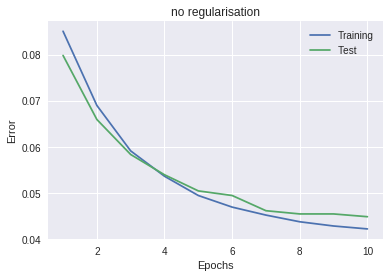

In [50]:
plt.figure()
plt.plot(range(1,num_epochs+1),1.0-np.array(acc_train),label='Training')
plt.plot(range(1,num_epochs+1),1.0-np.array(acc_test),label='Test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('no regularisation')
plt.legend()
# plt.savefig('problem1-accuracy1.pdf')
plt.show()

No handlers could be found for logger "matplotlib.legend"


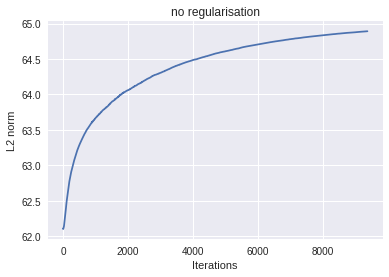

In [51]:
plt.figure()
plt.plot(range(1,len(l2_norm)+1),l2_norm)
plt.xlabel('Iterations')
plt.ylabel('L2 norm')
plt.title('no regularisation')
plt.legend()
# plt.savefig('problem1-accuracy1.pdf')
plt.show()

**L2 regularisation**

In [52]:
sizes=[784,800,800,10]
num_epochs = 10
batch_size = 64
lr0 = 0.02
momentum=0.0
cuda = False
weight_decay = 2.5/2.0

#define mlp net
model1 = MLPnet(sizes)
if cuda:
    model1 = model1.cuda()
    
model1.apply(model1.init_weights_glorot)
ll_train2,ll_valid2,ll_test2,acc_train2,acc_valid2,acc_test2,l2_norm2=\
    model1.train_model(torch.optim.SGD, lr0, momentum, weight_decay,
        num_epochs, batch_size, mnist_train,None,mnist_test, 10)

('Training Begining, Count of batchs:', 938)
Epoch:1, [NLL] TRAIN [0.31275803] / VALID 0 / TEST [0.2996288]
Epoch:1, [ACC] TRAIN 0.9092 / VALID 0 / TEST 0.9134
Epoch:10, [NLL] TRAIN [0.15297839] / VALID 0 / TEST [0.15770489]
Epoch:10, [ACC] TRAIN 0.95725 / VALID 0 / TEST 0.9544


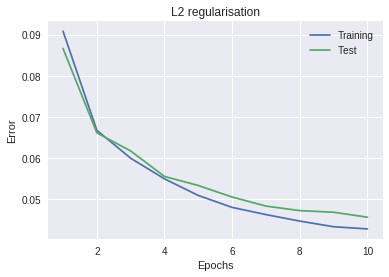

In [53]:
plt.figure()
plt.plot(range(1,num_epochs+1),1.0-np.array(acc_train2),label='Training')
plt.plot(range(1,num_epochs+1),1.0-np.array(acc_test2),label='Test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('L2 regularisation')
plt.legend()
# plt.savefig('problem1-accuracy1.pdf')
plt.show()

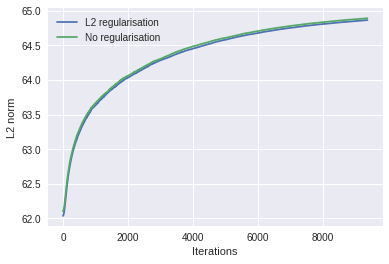

In [54]:
plt.figure()
plt.plot(range(1,len(l2_norm2)+1),l2_norm2,label='L2 regularisation')
plt.plot(range(1,len(l2_norm)+1),l2_norm,label='No regularisation')
plt.xlabel('Iterations')
plt.ylabel('L2 norm')
plt.legend()
# plt.savefig('problem1-accuracy1.pdf')
plt.show()